In [64]:
import os # Used to read the images path from the directory
import opendatasets as od

dataset_dir = "ASL Dataset"

if os.path.exists(dataset_dir) and os.listdir(dataset_dir):
    print("Dataset already exists and is not empty. Skipping download.")
else:
    print("Dataset not found or empty. Downloading...")
    od.download("https://www.kaggle.com/datasets/lexset/synthetic-asl-alphabet")

Dataset already exists and is not empty. Skipping download.


In [65]:
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode as IM
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os
from tqdm import tqdm
import time
import random
import numpy as np
import cv2 as cv
import HandTrackingModule as htm
import joblib

In [66]:
# Set seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [67]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device available:", device)

Device available: cuda


In [68]:
detector = htm.HandDetector(max_num_hands=1, min_detection_confidence=0.6, min_tracking_confidence=0.5)
detector_relaxed = htm.HandDetector(max_num_hands=1, min_detection_confidence=0.4, min_tracking_confidence=0.3)

def capture_hand_img(img_path):
    img = cv.imread(img_path)
    if img is None:
        return None
    
    handsInfo, frame = detector.findHands(img, draw=False)
    if not handsInfo:
        handsInfo, frame = detector_relaxed.findHands(img, draw=False)
    if not handsInfo:
        return None
    
    hand = handsInfo[0]
    x1, y1, x2, y2 = hand['bbox']

    # Adaptive offset
    hand_width = x2 - x1
    hand_height = y2 - y1
    adaptive_offset = int(max(20, min(hand_width, hand_height) * 0.15))

    # Clamp crop within frame bounds
    x1, y1 = max(0, x1 - adaptive_offset), max(0, y1 - adaptive_offset)
    x2, y2 = min(frame.shape[1], x2 + adaptive_offset), min(frame.shape[0], y2 + adaptive_offset)

    cropped_hand = frame[y1:y2, x1:x2]
    h, w = cropped_hand.shape[:2]

    if h == 0 or w == 0:
        return None

    # Resize with aspect ratio + padding
    bg_h, bg_w = (256, 256)
    aspect_ratio = w / h
    if aspect_ratio > 1:
        new_w, new_h = bg_w, int(bg_w / aspect_ratio)
    else:
        new_h, new_w = bg_h, int(bg_h * aspect_ratio)

    resized = cv.resize(cropped_hand, (new_w, new_h))
    img_new = np.full((bg_h, bg_w, 3), 128, dtype='uint8')

    x_offset, y_offset = (bg_w - new_w) // 2, (bg_h - new_h) // 2
    img_new[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

    return img_new

In [69]:
source_path = "ASL Dataset"
dest_path = "Cropped Hand Img"

splits = ["Train_Alphabet", "Test_Alphabet"]

# --- Loop over dataset ---
for split in splits:

    print(f"📂 Processing split: {split}")

    split_src = os.path.join(source_path, split)
    split_dst = os.path.join(dest_path, split)
    os.makedirs(split_dst, exist_ok=True)

    for folder in os.listdir(split_src):
        if folder.lower() == "blank":   # skip Blank folder
            continue  

        folder_src = os.path.join(split_src, folder)
        if not os.path.isdir(folder_src):
            continue

        folder_dst = os.path.join(split_dst, folder)
        os.makedirs(folder_dst, exist_ok=True)

        total, saved, skipped, already = 0, 0, 0, 0

        for fname in os.listdir(folder_src):
            img_path = os.path.join(folder_src, fname)
            if not os.path.isfile(img_path):
                continue

            total += 1
            save_path = os.path.join(folder_dst, fname)

            # ✅ Skip if file is already cropped and saved
            if os.path.exists(save_path):
                already += 1
                continue

            out_img = capture_hand_img(img_path)

            if out_img is None:
                skipped += 1
                continue

            ok = cv.imwrite(save_path, out_img)
            if ok:
                saved += 1
            else:
                skipped += 1

        print(f"{folder:4} | Total: {total:4} | Saved: {saved:4} | Skipped: {skipped:4} | Already: {already:4}")

print("\n✅ Processing complete. All valid images saved in", dest_path)

📂 Processing split: Train_Alphabet
A    | Total:  900 | Saved:    0 | Skipped:    0 | Already:  900
B    | Total:  900 | Saved:    0 | Skipped:    0 | Already:  900
C    | Total:  900 | Saved:    0 | Skipped:    0 | Already:  900
D    | Total:  900 | Saved:    0 | Skipped:    0 | Already:  900
E    | Total:  900 | Saved:    0 | Skipped:    0 | Already:  900
F    | Total:  900 | Saved:    0 | Skipped:    0 | Already:  900
G    | Total:  900 | Saved:    0 | Skipped:    1 | Already:  899
H    | Total:  900 | Saved:    0 | Skipped:    2 | Already:  898
I    | Total:  900 | Saved:    0 | Skipped:    0 | Already:  900
J    | Total:  900 | Saved:    0 | Skipped:    3 | Already:  897
K    | Total:  900 | Saved:    0 | Skipped:    0 | Already:  900
L    | Total:  900 | Saved:    0 | Skipped:    0 | Already:  900
M    | Total:  900 | Saved:    0 | Skipped:    0 | Already:  900
N    | Total:  900 | Saved:    0 | Skipped:    0 | Already:  900
O    | Total:  900 | Saved:    0 | Skipped:    0 | Alre

In [70]:
data = {"Train_Alphabet": {"Image Path": [], "Label": []},
        "Test_Alphabet": {"Image Path": [], "Label": []}}

for split in ["Train_Alphabet", "Test_Alphabet"]: 
    split_path = os.path.join("Cropped Hand Img", split)
    for folder in os.listdir(split_path):   
        folder_path = os.path.join(split_path, folder)
        if os.path.isdir(folder_path): 
            for image in os.listdir(folder_path): 
                image_path = os.path.join(folder_path, image)
                image_path = image_path.replace("\\", "/")
                data[split]["Image Path"].append(image_path) 
                data[split]["Label"].append(folder)

In [71]:
train_df = pd.DataFrame(data["Train_Alphabet"])
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df["Label"])
test_df = pd.DataFrame(data["Test_Alphabet"])

In [72]:
train_df = train_df.sort_values(by="Label").reset_index(drop=True)
val_df = val_df.sort_values(by="Label").reset_index(drop=True)

In [73]:
train_df

,Image Path,Label
0,Cropped Hand Img/Train_Alphabet/A/942d44ed-f69...,A
1,Cropped Hand Img/Train_Alphabet/A/1f199eac-71a...,A
2,Cropped Hand Img/Train_Alphabet/A/431501f9-c8d...,A
3,Cropped Hand Img/Train_Alphabet/A/d581b09c-f63...,A
4,Cropped Hand Img/Train_Alphabet/A/11f5a738-2eb...,A
...,...,...
17537,Cropped Hand Img/Train_Alphabet/Z/522a45bd-f4d...,Z
17538,Cropped Hand Img/Train_Alphabet/Z/38d89bde-ce5...,Z
17539,Cropped Hand Img/Train_Alphabet/Z/72e674c3-5dc...,Z
17540,Cropped Hand Img/Train_Alphabet/Z/461fe45b-0d3...,Z


In [74]:
val_df

,Image Path,Label
0,Cropped Hand Img/Train_Alphabet/A/1153c07a-4de...,A
1,Cropped Hand Img/Train_Alphabet/A/5bcd9e70-afe...,A
2,Cropped Hand Img/Train_Alphabet/A/7360ee94-437...,A
3,Cropped Hand Img/Train_Alphabet/A/55ab06c5-03a...,A
4,Cropped Hand Img/Train_Alphabet/A/f1b6e166-2b4...,A
...,...,...
5843,Cropped Hand Img/Train_Alphabet/Z/aa43be9a-9c7...,Z
5844,Cropped Hand Img/Train_Alphabet/Z/b914d3cd-711...,Z
5845,Cropped Hand Img/Train_Alphabet/Z/cd6e1b13-d52...,Z
5846,Cropped Hand Img/Train_Alphabet/Z/88fad18e-570...,Z


In [75]:
test_df

,Image Path,Label
0,Cropped Hand Img/Test_Alphabet/A/081a8b28-7394...,A
1,Cropped Hand Img/Test_Alphabet/A/09a13b4f-b68f...,A
2,Cropped Hand Img/Test_Alphabet/A/09ea96a0-eb7b...,A
3,Cropped Hand Img/Test_Alphabet/A/0de66b7e-1449...,A
4,Cropped Hand Img/Test_Alphabet/A/103a0979-29c7...,A
...,...,...
2595,Cropped Hand Img/Test_Alphabet/Z/f60f518a-c8b0...,Z
2596,Cropped Hand Img/Test_Alphabet/Z/fbdcddd1-f4f7...,Z
2597,Cropped Hand Img/Test_Alphabet/Z/fd007a3c-8690...,Z
2598,Cropped Hand Img/Test_Alphabet/Z/fe7beb8c-6ddd...,Z


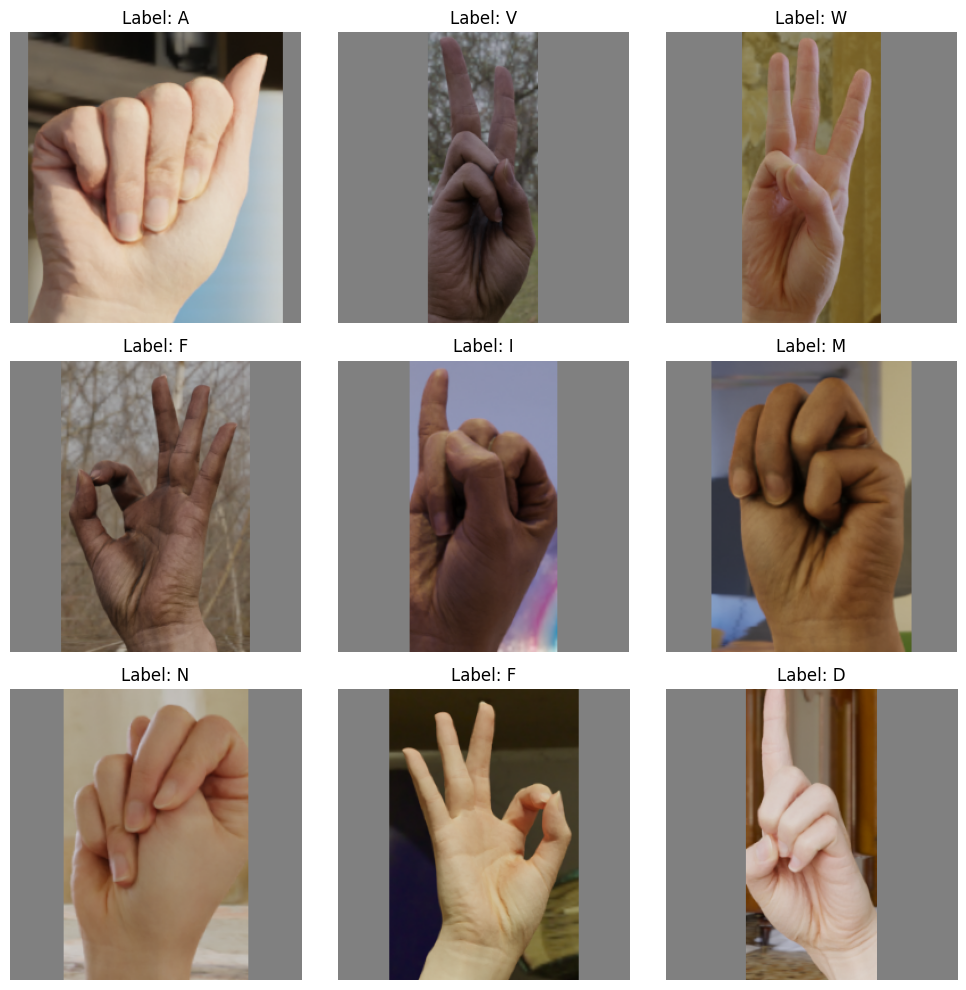

In [76]:
rows = 3
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for row in range(rows):
    for col in range(cols):
        sample = train_df.sample(1).iloc[0]   # pick one random row
        img_path = sample['Image Path']
        label = sample['Label']               # assumes your DataFrame has a 'Label' column

        image = Image.open(img_path).convert('RGB')
        axes[row][col].imshow(image)
        axes[row][col].set_title(f'Label: {label}')       # ✅ add label as title
        axes[row][col].axis('off')

plt.tight_layout()
plt.show()

In [77]:
encoder = LabelEncoder()
encoder.fit(train_df['Label'])

LabelEncoder()

In [78]:
# Enhanced transforms with data augmentation for training

train_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=IM.BICUBIC, antialias=True),
    transforms.RandomRotation(30, interpolation=IM.BILINEAR, fill=128),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.4, contrast=0.4),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [79]:
# Simple transform for test (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=IM.BICUBIC, antialias=True),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [80]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.labels = torch.tensor(encoder.transform(dataframe['Label']), dtype=torch.long)
    
    def __len__(self):
        return len(self.dataframe)
   
    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        
        try:
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return a blank image if there's an error
            return torch.zeros((1, 128, 128)), label

In [81]:
train_dataset = CustomImageDataset(dataframe=train_df, transform=train_transform)
val_dataset = CustomImageDataset(dataframe=val_df, transform=test_transform)
test_dataset = CustomImageDataset(dataframe=test_df, transform=test_transform)

In [82]:
print('Train Dataset:', len(train_dataset))
print('Validation Dataset:', len(val_dataset))
print('Test Dataset:', len(test_dataset))
print('Number of classes:', len(train_df['Label'].unique()))

Train Dataset: 17542
Validation Dataset: 5848
Test Dataset: 2600
Number of classes: 26


In [83]:
train_dataset.__getitem__(random.randint(0, len(train_dataset)))

(tensor([[[0.0824, 0.0824, 0.0824,  ..., 0.0824, 0.0824, 0.0824],
          [0.0824, 0.0824, 0.0824,  ..., 0.0824, 0.0824, 0.0824],
          [0.0824, 0.0824, 0.0824,  ..., 0.0824, 0.0824, 0.0824],
          ...,
          [0.0824, 0.0824, 0.0824,  ..., 0.0824, 0.0824, 0.0824],
          [0.0824, 0.0824, 0.0824,  ..., 0.0824, 0.0824, 0.0824],
          [0.0824, 0.0824, 0.0824,  ..., 0.0824, 0.0824, 0.0824]]]),
 tensor(5))

In [84]:
BATCH_SIZE = 16
EPOCHS = 20
LR = 1e-4
WEIGHT_DECAY = 1e-4

In [85]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

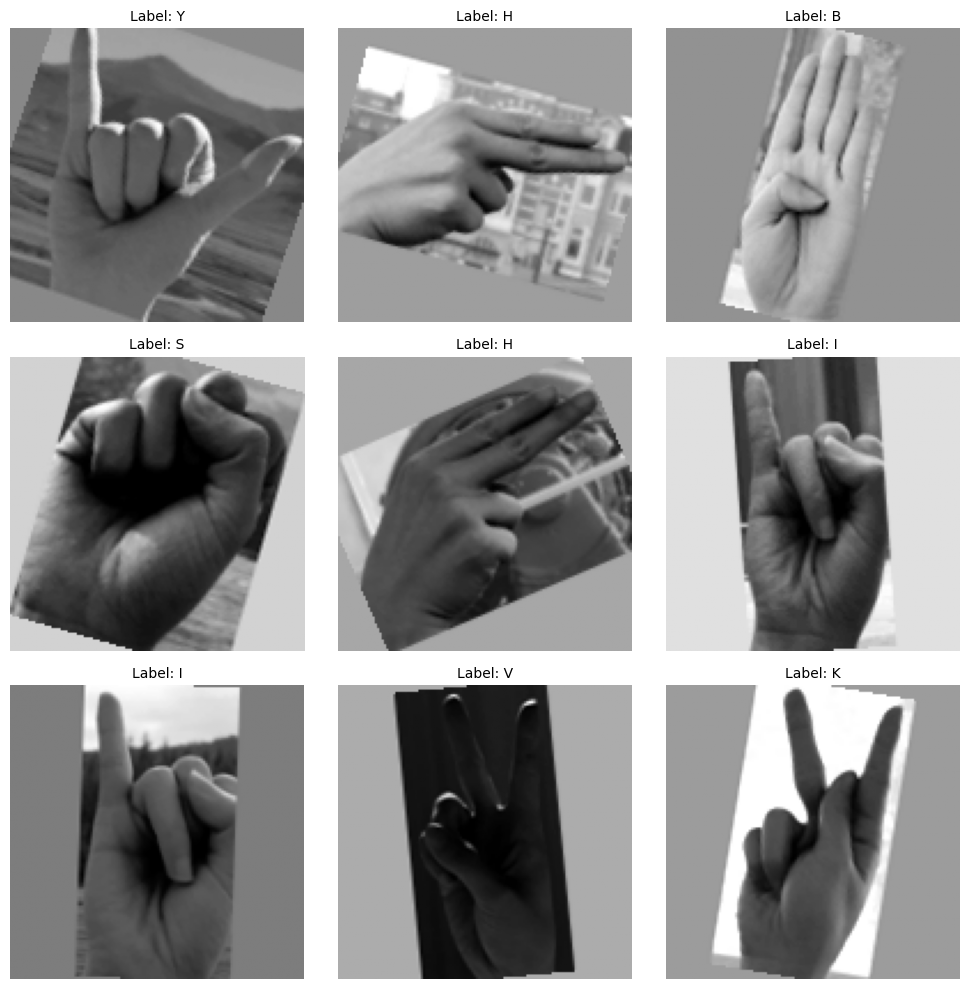

In [86]:
# Grab one batch from the dataloader
data_iter = iter(train_loader)
images, labels = next(data_iter)   # images: [B, 1, H, W]

# Pick 9 random indices from this batch
indices = torch.randperm(images.size(0))[:9]

rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for ax, idx in zip(axes.flatten(), indices):
    img = images[idx]

    # Unnormalize (because you normalized with mean=0.5, std=0.5)
    img_display = img.squeeze(0).cpu().numpy() * 0.5 + 0.5  # back to [0,1]

    # Decode label if you have an encoder
    label = labels[idx].item()
    actual_label = encoder.inverse_transform([label])[0]  # if using LabelEncoder

    ax.imshow(img_display, cmap="gray")
    ax.set_title(f"Label: {actual_label}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [87]:
class SignLanguageClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)

        self.pooling = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))

        # Use lighter spatial dropout for conv features
        self.drop_conv = nn.Dropout2d(p=0.15)
        # Use stronger dropout for the classifier head
        self.drop_fc   = nn.Dropout(p=0.40)

        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 128)
        self.output = nn.Linear(128, num_classes)

    def forward(self, x):
        for bn, conv in zip([self.bn1, self.bn2, self.bn3], [self.conv1, self.conv2, self.conv3]):
            x = self.pooling(F.relu(bn(conv(x))))
            x = self.drop_conv(x)

        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x)); x = self.drop_fc(x)
        x = F.relu(self.fc2(x)); x = self.drop_fc(x)
        return self.output(x)


In [88]:
# Initialize improved model
num_classes = len(train_df['Label'].unique())
model = SignLanguageClassifier(num_classes).to(device)

In [89]:
# Loss and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [90]:
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

c:\Users\suzanne.gharib\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [91]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

Starting training with validation and early stopping...


Epoch 1/20 | Train Loss: 2.7769 | Train Acc: 14.14% | Val Loss: 1.9788 | Val Acc: 39.31% | Test Acc: 39.69% | Time: 82.6s | ETA: --:--


Epoch 2/20 | Train Loss: 2.0101 | Train Acc: 33.06% | Val Loss: 1.1122 | Val Acc: 72.16% | Test Acc: 70.69% | Time: 81.5s | ETA: 24:36


Epoch 3/20 | Train Loss: 1.5004 | Train Acc: 49.21% | Val Loss: 0.7463 | Val Acc: 81.41% | Test Acc: 80.27% | Time: 83.1s | ETA: 23:20


Epoch 4/20 | Train Loss: 1.2267 | Train Acc: 58.33% | Val Loss: 0.5208 | Val Acc: 87.67% | Test Acc: 86.92% | Time: 82.1s | ETA: 21:57


Epoch 5/20 | Train Loss: 1.0495 | Train Acc: 64.63% | Val Loss: 0.4051 | Val Acc: 89.91% | Test Acc: 89.54% | Time: 82.1s | ETA: 20:34


Epoch 6/20 | Train Loss: 0.8915 | Train Acc: 69.79% | Val Loss: 0.3211 | Val Acc: 91.72% | Test Acc: 91.27% | Time: 82.1s | ETA: 19:11


Epoch 7/20 | Train Loss: 0.8066 | Train Acc: 73.10% | Val Loss: 0.2837 | Val Acc: 92.34% | Test Acc: 91.77% | Time: 82.2s | ETA: 17:49


Epoch 8/20 | Train Loss: 0.7304 | Train Acc: 75.74% | Val Loss: 0.2342 | Val Acc: 93.81% | Test Acc: 93.12% | Time: 81.7s | ETA: 16:26


Epoch 9/20 | Train Loss: 0.6738 | Train Acc: 77.77% | Val Loss: 0.2185 | Val Acc: 94.03% | Test Acc: 93.65% | Time: 81.9s | ETA: 15:03


Epoch 10/20 | Train Loss: 0.6177 | Train Acc: 79.30% | Val Loss: 0.1865 | Val Acc: 95.25% | Test Acc: 94.69% | Time: 82.2s | ETA: 13:41


Epoch 11/20 | Train Loss: 0.5951 | Train Acc: 80.53% | Val Loss: 0.2064 | Val Acc: 94.05% | Test Acc: 93.42% | Time: 82.0s | ETA: 12:19


Epoch 12/20 | Train Loss: 0.5501 | Train Acc: 81.91% | Val Loss: 0.1653 | Val Acc: 95.73% | Test Acc: 95.23% | Time: 82.4s | ETA: 10:57


Epoch 13/20 | Train Loss: 0.5242 | Train Acc: 82.81% | Val Loss: 0.1627 | Val Acc: 95.33% | Test Acc: 95.15% | Time: 189.8s | ETA: 10:33


Epoch 14/20 | Train Loss: 0.4920 | Train Acc: 83.73% | Val Loss: 0.1397 | Val Acc: 95.93% | Test Acc: 96.12% | Time: 80.9s | ETA: 08:58


Epoch 15/20 | Train Loss: 0.4741 | Train Acc: 84.60% | Val Loss: 0.1339 | Val Acc: 96.41% | Test Acc: 95.85% | Time: 81.3s | ETA: 07:26


Epoch 16/20 | Train Loss: 0.4486 | Train Acc: 85.51% | Val Loss: 0.1268 | Val Acc: 96.60% | Test Acc: 96.46% | Time: 81.6s | ETA: 05:54


Epoch 17/20 | Train Loss: 0.4250 | Train Acc: 86.12% | Val Loss: 0.1179 | Val Acc: 96.65% | Test Acc: 96.69% | Time: 81.9s | ETA: 04:24


Epoch 18/20 | Train Loss: 0.4193 | Train Acc: 86.54% | Val Loss: 0.1198 | Val Acc: 96.46% | Test Acc: 96.50% | Time: 81.6s | ETA: 02:55


Epoch 19/20 | Train Loss: 0.4061 | Train Acc: 86.96% | Val Loss: 0.1128 | Val Acc: 96.84% | Test Acc: 96.46% | Time: 81.3s | ETA: 01:27


Epoch 20/20 | Train Loss: 0.3775 | Train Acc: 87.92% | Val Loss: 0.1059 | Val Acc: 96.96% | Test Acc: 96.92% | Time: 83.0s | ETA: 00:00


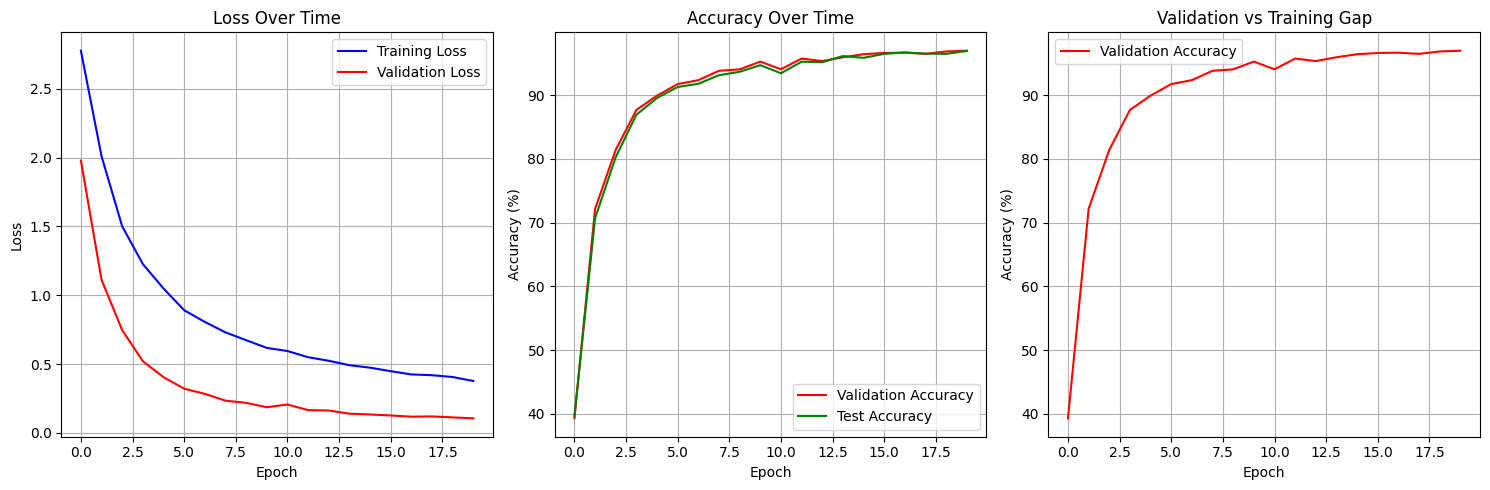


Best Validation Accuracy: 96.96%

Loading best model for final evaluation...


C:\Users\suzanne.gharib\AppData\Local\Temp\ipykernel_29228\3402243255.py:172: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_sign_language_model

Final Test Accuracy with Best Model: 96.92%


In [ ]:
# Training loop with validation and early stopping
def train_and_evaluate():
    train_losses = []
    val_losses = []
    test_accuracies = []
    val_accuracies = []
    best_test_acc = 0.0
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True)
    
    training_start_time = time.time()
    
    for epoch in range(EPOCHS):
        epoch_start_time = time.time()
        
        # Training phase
        model.train()
        total_correct = 0
        total_samples = 0
        total_loss = 0.0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} - Training', leave=False, ncols=100)
        
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == labels).sum().item()
            total_samples += labels.size(0)
            
            current_acc = 100 * total_correct / total_samples
            current_loss = total_loss / (train_pbar.n + 1)
            train_pbar.set_postfix({'Loss': f'{current_loss:.4f}', 'Acc': f'{current_acc:.2f}%'})

        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{EPOCHS} - Validation', leave=False, ncols=100)
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()
                val_total += labels.size(0)
        
        # Test phase (for final evaluation)
        test_correct = 0
        test_total = 0
        test_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                test_correct += (outputs.argmax(dim=1) == labels).sum().item()
                test_total += labels.size(0)
        
        # Calculate metrics
        train_acc = 100 * total_correct / total_samples
        train_loss = total_loss / len(train_loader)
        val_acc = 100 * val_correct / val_total
        val_loss_avg = val_loss / len(val_loader)
        test_acc = 100 * test_correct / test_total
        test_loss_avg = test_loss / len(test_loader)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)
        
        # Learning rate scheduling based on validation loss
        scheduler.step(val_loss_avg)
        
        # Save best model based on validation accuracy
        if val_acc > best_test_acc:
            best_test_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss_avg,
            }, 'best_sign_language_model.pth')
        
        # Calculate timing
        epoch_time = time.time() - epoch_start_time
        elapsed_time = time.time() - training_start_time
        
        if epoch > 0:
            avg_epoch_time = elapsed_time / (epoch + 1)
            remaining_epochs = EPOCHS - (epoch + 1)
            eta = remaining_epochs * avg_epoch_time
            eta_str = f"ETA: {int(eta//60):02d}:{int(eta%60):02d}"
        else:
            eta_str = "ETA: --:--"
        
        print(f"Epoch {epoch+1}/{EPOCHS} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss_avg:.4f} | Val Acc: {val_acc:.2f}% | "
              f"Test Acc: {test_acc:.2f}% | "
              f"Time: {epoch_time:.1f}s | {eta_str}")
        
        # Early stopping check
        if early_stopping(val_loss_avg, model):
            print(f"Early stopping triggered at epoch {epoch+1}")
            print(f"Best validation loss: {early_stopping.best_loss:.4f}")
            break
        
        # Additional overfitting warning
        if epoch > 5 and train_acc - val_acc > 20:
            print(f"Large gap between training ({train_acc:.1f}%) and validation ({val_acc:.1f}%) accuracy detected")
    
    return train_losses, val_losses, val_accuracies, test_accuracies, best_test_acc

# Run training
print("Starting training with validation and early stopping...")
train_losses, val_losses, val_accuracies, test_accuracies, best_val_acc = train_and_evaluate()



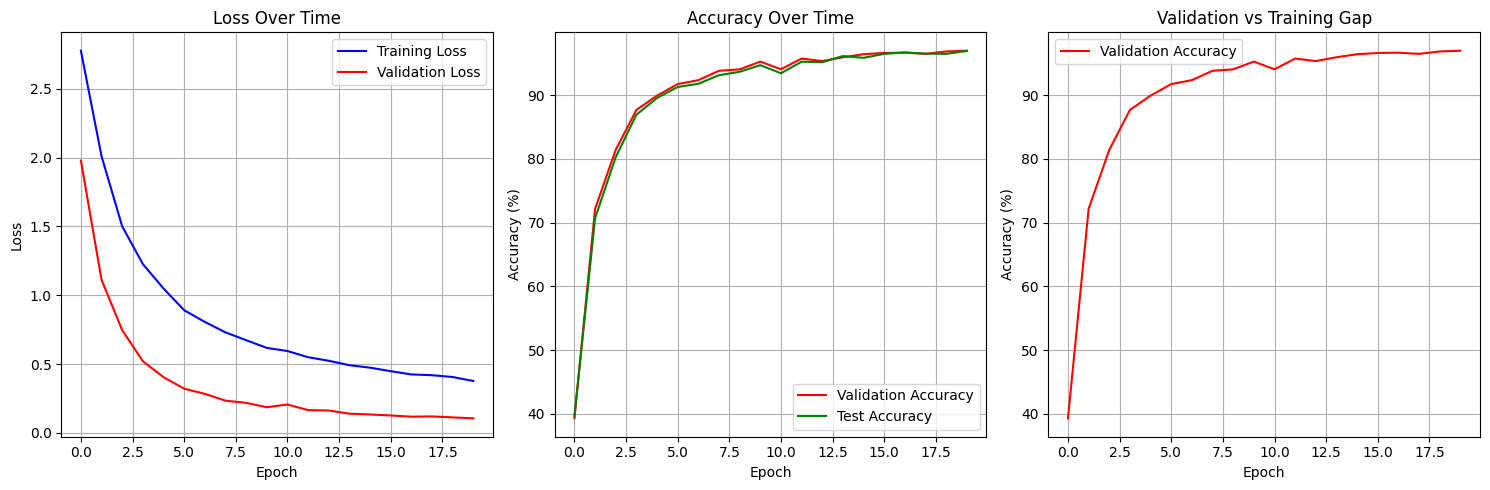


Best Validation Accuracy: 96.96%

Loading best model for final evaluation...


C:\Users\suzanne.gharib\AppData\Local\Temp\ipykernel_29228\717601469.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_sign_language_model.p

Final Test Accuracy with Best Model: 96.92%


In [94]:
# Plot training progress
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
# Calculate training accuracy from the training process for comparison
train_accs = []  # This would need to be collected during training
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.title('Validation vs Training Gap')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nBest Validation Accuracy: {best_val_acc:.2f}%")

# Load the best model for final evaluation
print("\nLoading best model for final evaluation...")
checkpoint = torch.load('best_sign_language_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Final test evaluation
model.eval()
final_test_correct = 0
final_test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        final_test_correct += (outputs.argmax(dim=1) == labels).sum().item()
        final_test_total += labels.size(0)

final_test_accuracy = 100 * final_test_correct / final_test_total
print(f"Final Test Accuracy with Best Model: {final_test_accuracy:.2f}%")

In [93]:
def analyze_predictions():
    model.eval()
    all_predictions = []
    all_labels = []
    all_confidences = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            max_probs, predictions = torch.max(probs, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidences.extend(max_probs.cpu().numpy())
    
    # Convert back to class names
    pred_names = encoder.inverse_transform(all_predictions)
    true_names = encoder.inverse_transform(all_labels)
    
    # Create confusion analysis
    results_df = pd.DataFrame({
        'True_Label': true_names,
        'Predicted_Label': pred_names,
        'Confidence': all_confidences,
        'Correct': np.array(all_predictions) == np.array(all_labels)
    })
    
    print("\n=== PREDICTION ANALYSIS ===")
    print(f"Overall Accuracy: {results_df['Correct'].mean():.3f}")
    print(f"Average Confidence: {results_df['Confidence'].mean():.3f}")
    print(f"Confidence on Correct: {results_df[results_df['Correct']]['Confidence'].mean():.3f}")
    print(f"Confidence on Incorrect: {results_df[~results_df['Correct']]['Confidence'].mean():.3f}")
    
    print("\nMost Confused Classes:")
    confusion_by_class = results_df.groupby('True_Label')['Correct'].mean().sort_values()
    print(confusion_by_class.head())
    
    print("\nMost Common Misclassifications:")
    wrong_preds = results_df[~results_df['Correct']]
    if len(wrong_preds) > 0:
        misclass = wrong_preds.groupby(['True_Label', 'Predicted_Label']).size().sort_values(ascending=False)
        print(misclass.head())
    
    return results_df

# Run analysis
results = analyze_predictions()


=== PREDICTION ANALYSIS ===
Overall Accuracy: 0.969
Average Confidence: 0.956
Confidence on Correct: 0.966
Confidence on Incorrect: 0.649

Most Confused Classes:
True_Label
D    0.88
J    0.91
G    0.94
Q    0.94
P    0.94
Name: Correct, dtype: float64

Most Common Misclassifications:
True_Label  Predicted_Label
D           X                  6
J           Q                  5
H           G                  4
J           G                  3
Q           J                  3
dtype: int64


In [252]:
joblib.dump(encoder, 'label_encoder.pkl')

['label_encoder.pkl']